<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/NRTMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'

In [ ]:
# Define plot matrix function
def plotMatrix(data, plotName):
  plt.figure(figsize = (14, 9))
  plt.title(f'{plotName}')
  ax = sns.heatmap(data,
              annot = True,
              fmt = '.2%',
              xticklabels = True,
              yticklabels = True,
              cmap = 'RdYlGn_r',
              cbar = False)
  ax.xaxis.tick_top() # x axis on top
  ax.xaxis.set_label_position('top')
  return plt.show()

In [ ]:
# Import dataset
# Non-Retatil count rating
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/ratingMatrix.csv')
df.head(5)

,Segment,Rating,Rating12,N
0,SME,AA,AA,39
1,SME,AA,A+,3
2,SME,AA,BBB,1
3,SME,A+,Closed,14
4,SME,A+,A+,49


In [ ]:
# Count matrix
matrix = pd.pivot_table(df,
                        values = 'N',
                        index = ['Rating'],
                        columns = ['Rating12'],
                        aggfunc = sum).fillna(0)

# Sort index and columns by rating
colsRating = ['AAA', 'AA', 'A+', 'A', 'BBB+', 'BBB', 'BB+', 'BB', 'B+',
               'B', 'CCC', 'CC', 'C+', 'C', 'Closed', 'Default']
indexRating = ['AAA', 'AA', 'A+', 'A', 'BBB+', 'BBB', 'BB+', 'BB', 'B+',
               'B', 'CCC', 'CC', 'C+', 'C', 'Default']
matrix = matrix[colsRating] #Sort columns
matrix.index = matrix.index.str.strip()
matrix = matrix.reindex(indexRating) #Sort index
matrix

Rating12,AAA,AA,A+,A,BBB+,BBB,BB+,BB,B+,B,CCC,CC,C+,C,Closed,Default
Rating,,,,,,,,,,,,,,,,
AAA,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA,0.0,114.0,6.0,0.0,2.0,16.0,0.0,0.0,0.0,1.0,0.0,7.0,1.0,0.0,6.0,0.0
A+,3.0,57.0,218.0,30.0,18.0,12.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,14.0,0.0
A,12.0,41.0,75.0,358.0,129.0,67.0,39.0,0.0,13.0,1.0,11.0,1.0,0.0,0.0,19.0,0.0
BBB+,0.0,24.0,52.0,163.0,787.0,187.0,114.0,68.0,30.0,25.0,0.0,5.0,12.0,0.0,33.0,0.0
BBB,0.0,17.0,26.0,101.0,251.0,733.0,357.0,163.0,47.0,56.0,0.0,5.0,3.0,0.0,91.0,6.0
BB+,0.0,0.0,22.0,36.0,134.0,345.0,2618.0,987.0,674.0,261.0,147.0,96.0,57.0,32.0,339.0,38.0
BB,0.0,0.0,1.0,14.0,24.0,87.0,844.0,1634.0,1170.0,487.0,288.0,161.0,98.0,22.0,385.0,85.0
B+,0.0,0.0,0.0,12.0,44.0,48.0,501.0,1055.0,3911.0,1373.0,806.0,445.0,269.0,76.0,690.0,164.0


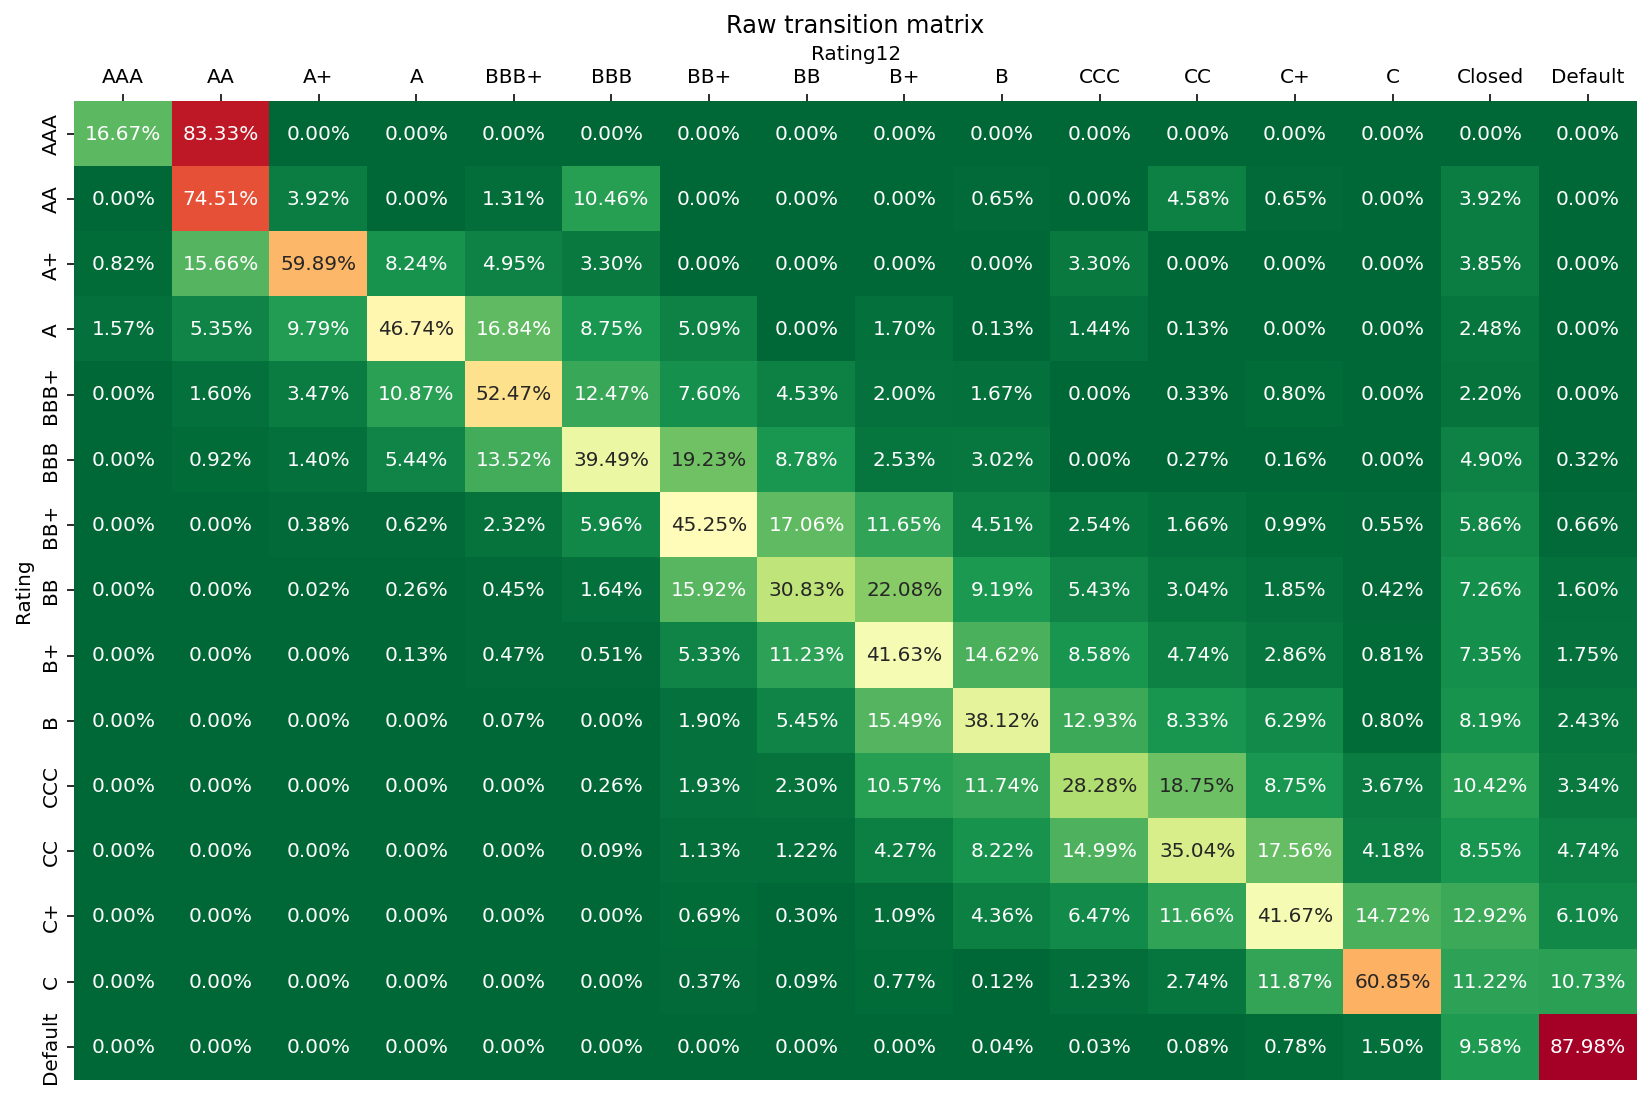

In [ ]:
# Transition matrix
matrix = matrix.div(matrix.sum(axis = 1), axis = 0)

# Plot
plotMatrix(matrix, 'Raw transition matrix')

In [ ]:
# Define function for reference transition row
def refRow(input, ref):
  data = pd.DataFrame.copy(input)
  refNum = list(data.index).index(ref)
  dataArray = data.to_numpy()
  row = dataArray[refNum, :-2] #Without 'Closed' and 'Default'
  closeDefault = dataArray[refNum, -2:] #'Closed' and 'Default'
  for i in range(dataArray.shape[0]):
    newRow = np.hstack((row[refNum - i:], np.repeat(0, refNum - i), closeDefault)) #Create reference row
    adjRate = np.sum(row[0:refNum - i])
    newRowAdj = newRow / (1 - adjRate) #Adjustment row to 100%
    dataArray[i] = newRowAdj #Apply reference row adjustment
    if i == refNum:
      dfMatrix = pd.DataFrame(dataArray,
                              columns = data.columns,
                              index = data.index)
      return dfMatrix

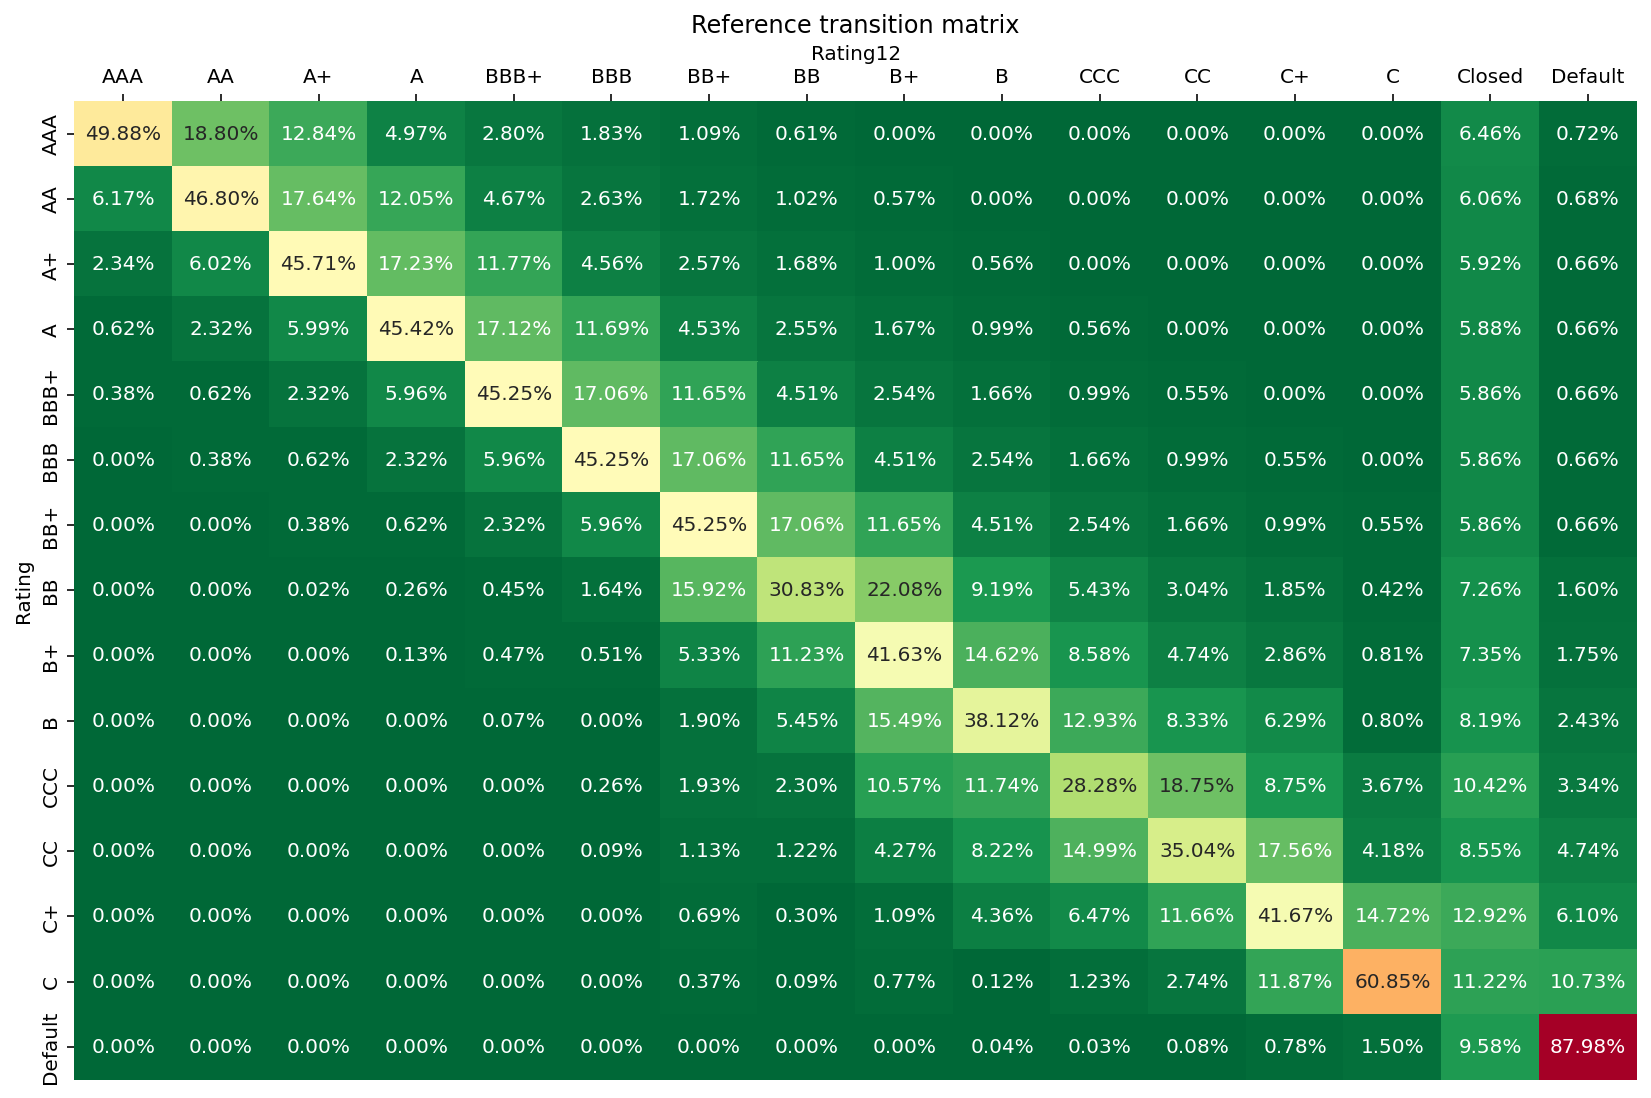

In [ ]:
# Reference transition matrix row
matrixRef = refRow(matrix, 'BB+')

# Plot
plotMatrix(matrixRef, 'Reference transition matrix')

In [ ]:
# Define plot rate function
def plotRate(data, name, xvar, yvar, linevar = None):
  plt.figure(figsize = (12, 7))
  with plt.style.context('seaborn-deep'):
    ax = sns.scatterplot(x = xvar, y = yvar, data = data)
    if linevar is not None:
      ax = sns.lineplot(x = data.index, y = linevar, data = data, color = 'orange')
    ax.set_title(name)
    ax.set(xlabel = f'{xvar}', ylabel = f'{yvar}')      
  return plt.show()

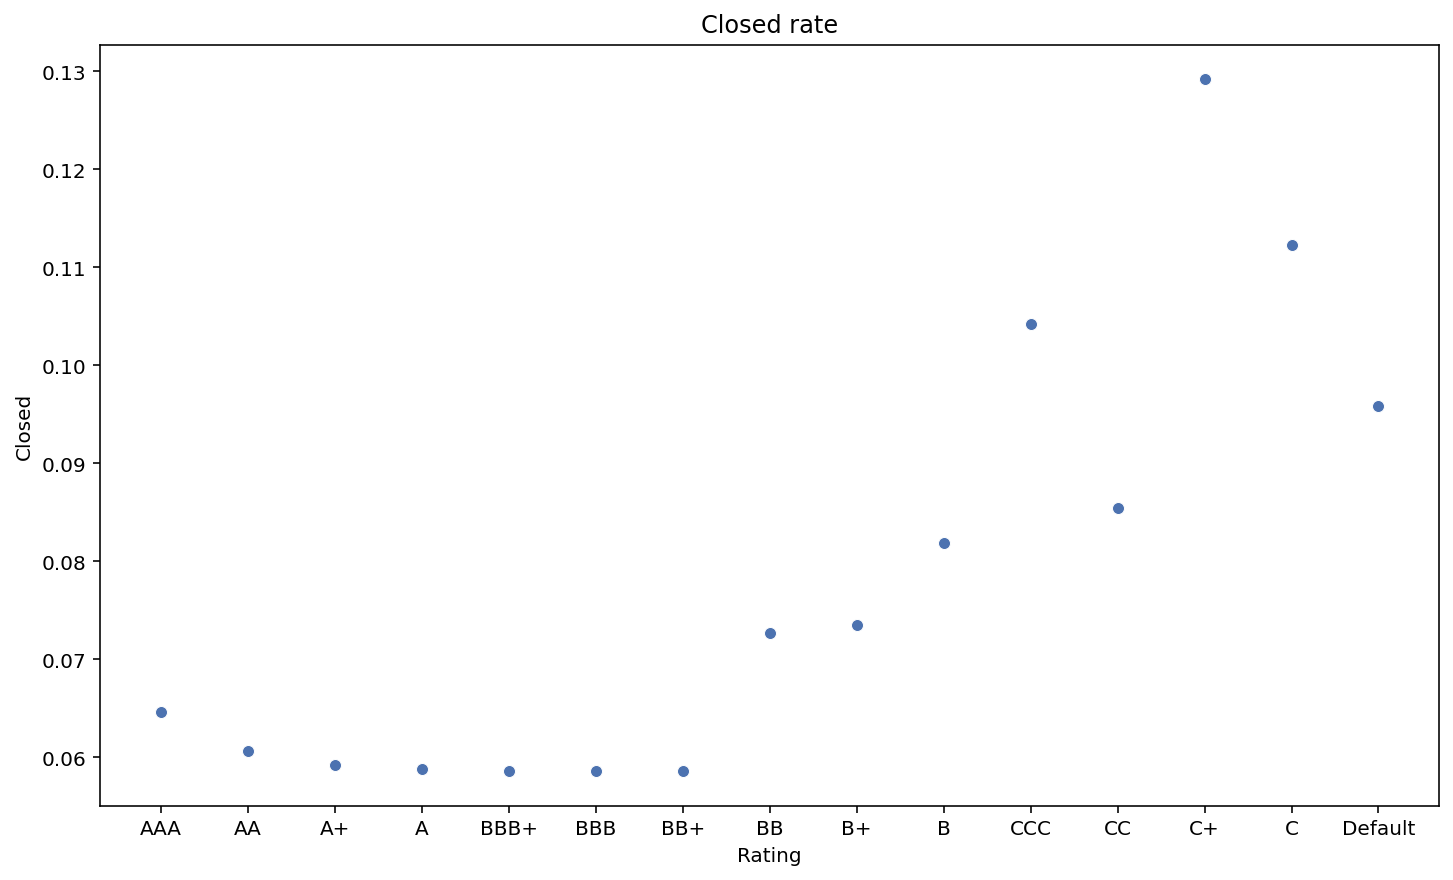

In [ ]:
# Plot
plotRate(matrixRef, 'Closed rate', 'Rating', 'Closed')

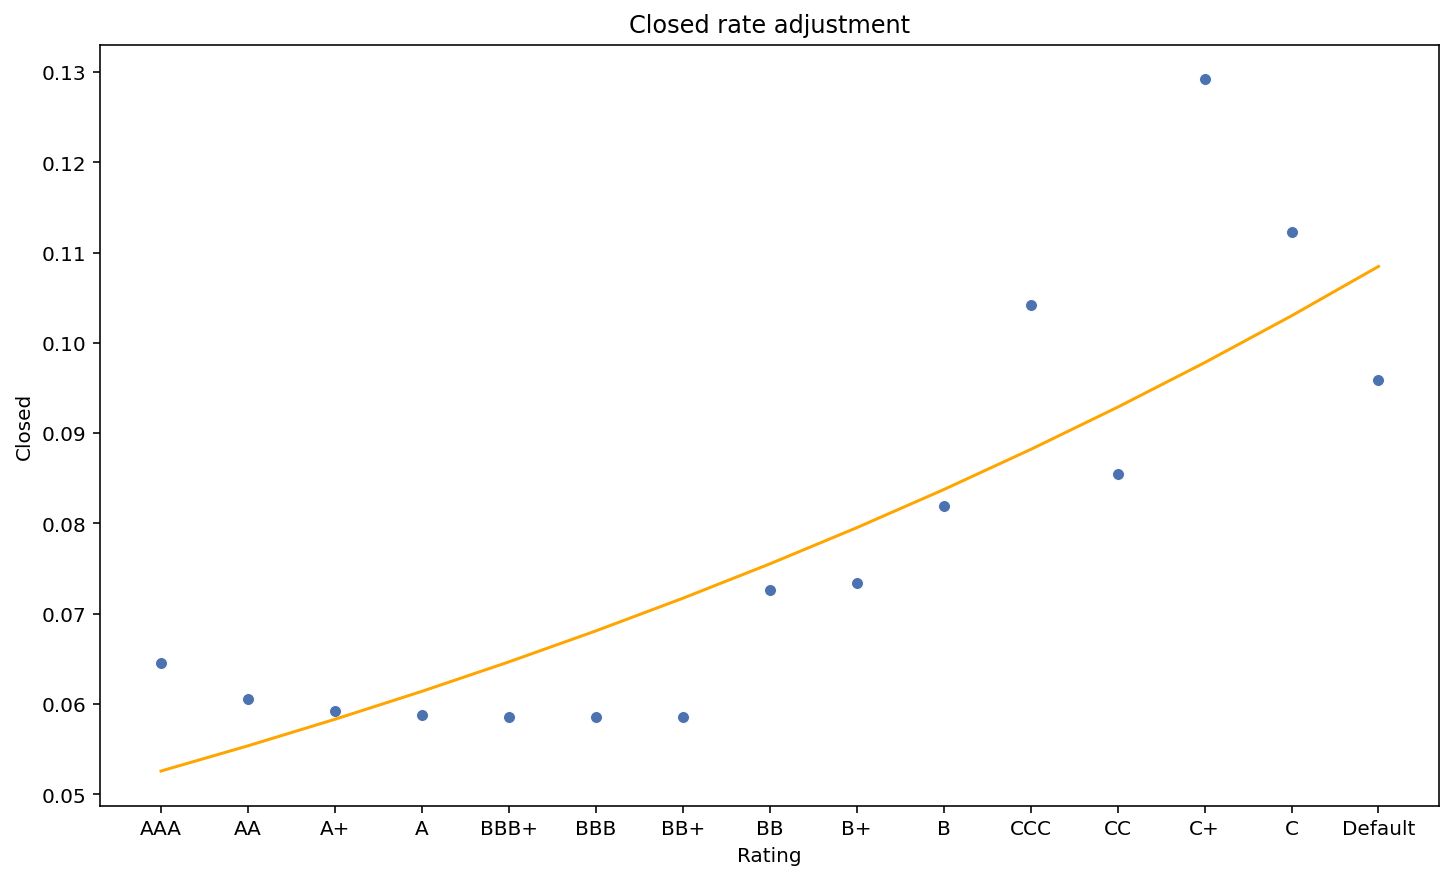

In [ ]:
# Closed rate adjustment
# Observed closed rate
X = np.arange(matrixRef.shape[0]).reshape(-1, 1)
y = np.array(matrixRef['Closed']).reshape(-1, 1)

# Log-linear regression model
model = LinearRegression()
model.fit(X, np.log(y))

# Result
matrixRef['Closed Adj'] = np.exp(model.predict(X)).reshape(1, -1)[0]

# Plot
plotRate(matrixRef, 'Closed rate adjustment', 'Rating', 'Closed', 'Closed Adj')

In [ ]:
# Define function rate matrix adjustment
def adjMatrix(data, oldRate, newRate):
  adjRate = (1 - data[newRate]).values / (1 - data[oldRate]).values
  matrixAdj = data.drop([oldRate, newRate], axis = 1).mul(adjRate, axis = 0)
  matrixAdj[f'{newRate}'] = list(data[newRate])
  return matrixAdj

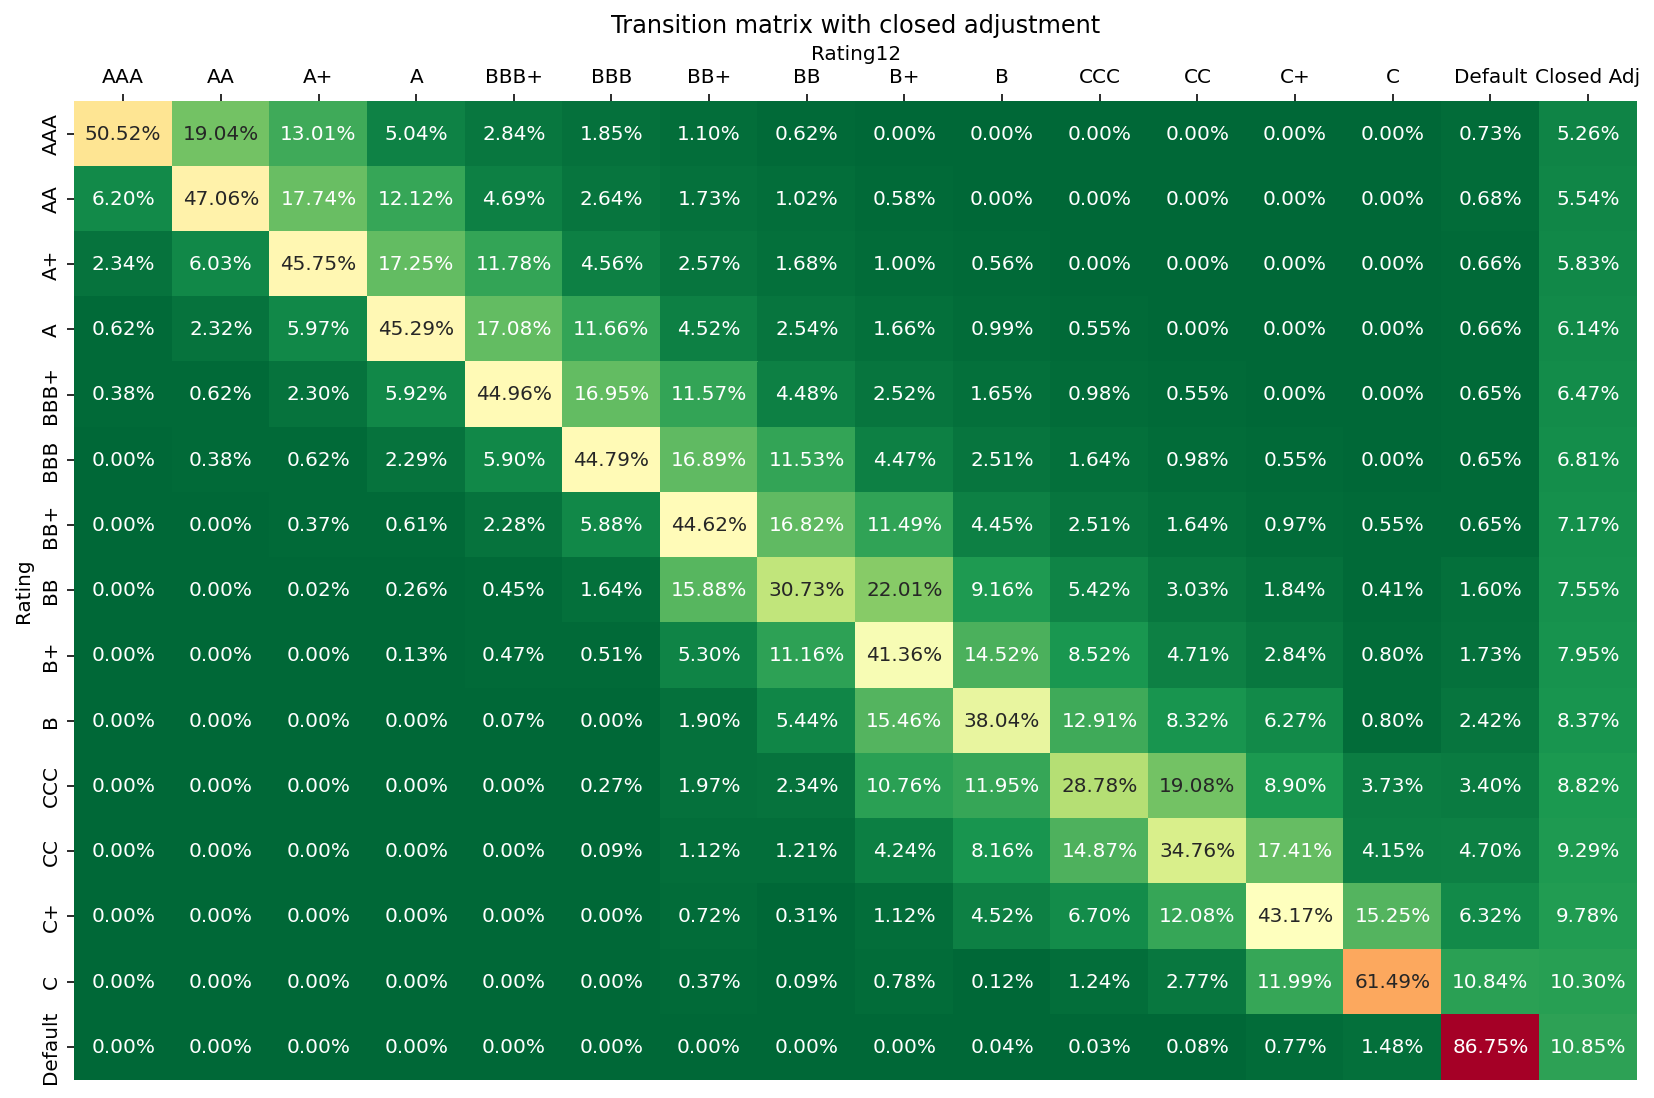

In [ ]:
# Matrix adjusted by closed rate adjustment
matrixAdj = adjMatrix(matrixRef, 'Closed', 'Closed Adj')

# Plot
plotMatrix(matrixAdj, 'Transition matrix with closed adjustment')

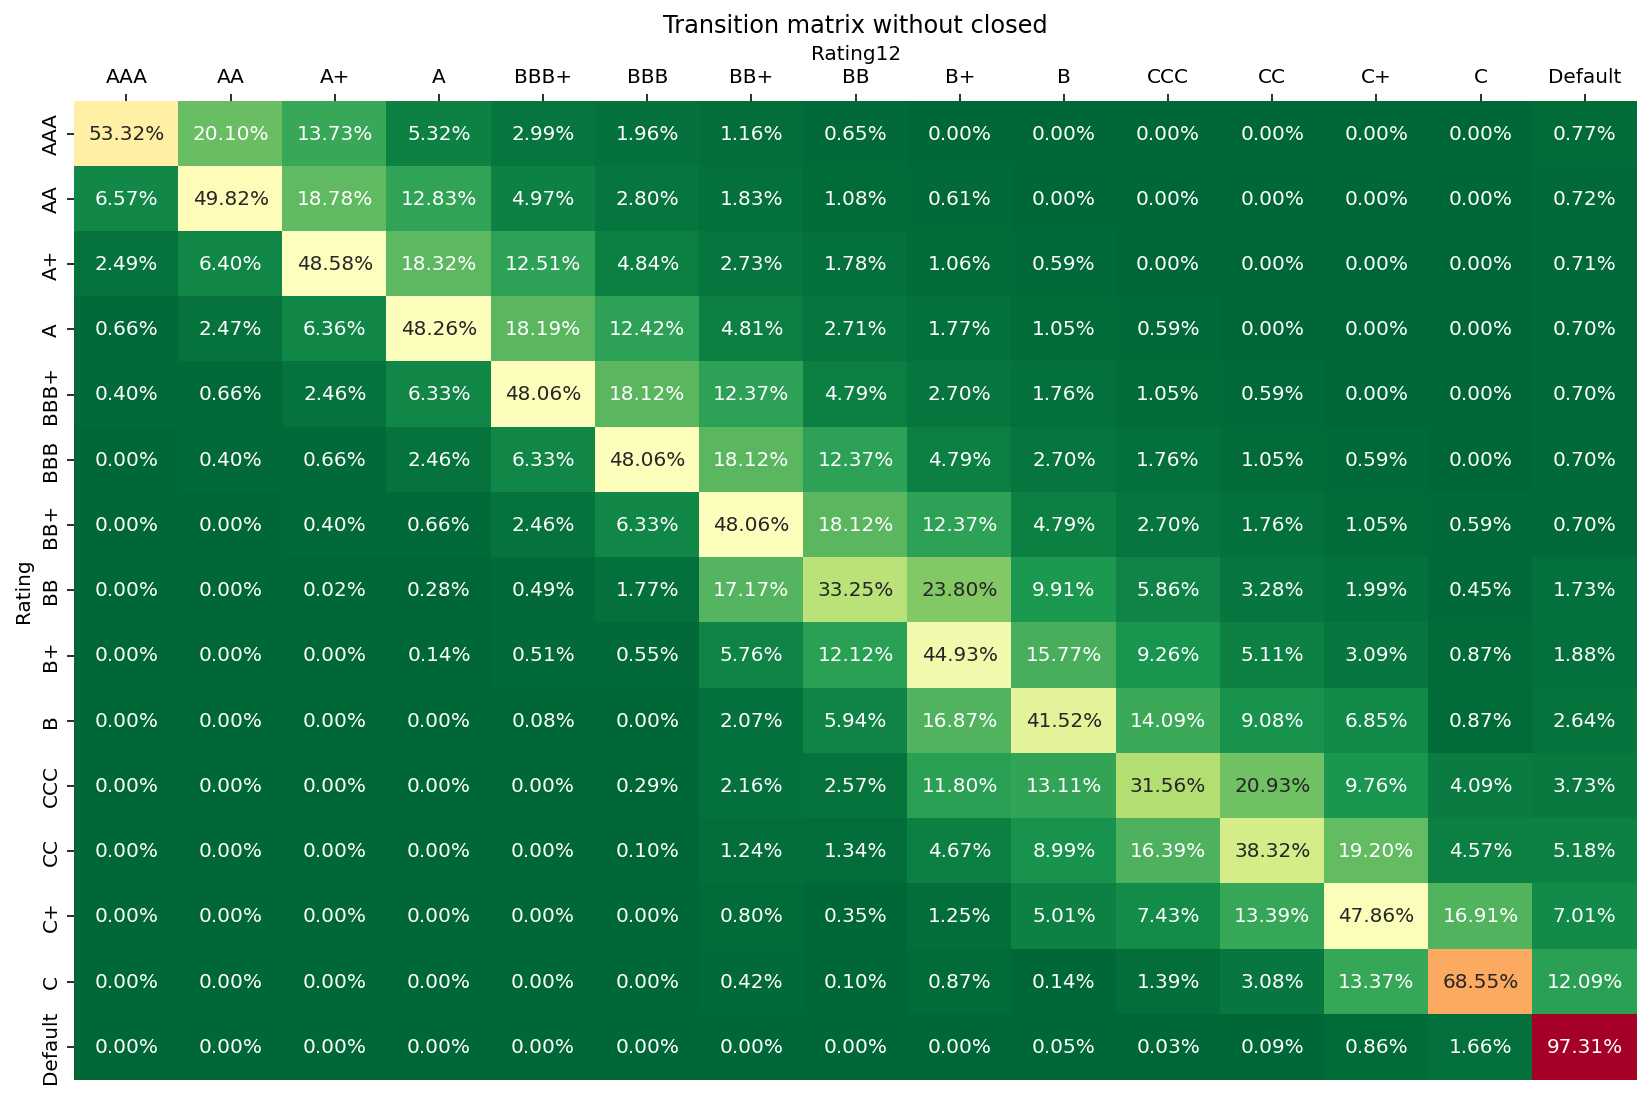

In [ ]:
# Matrix adjusted by remove closed rate
matrixAdj = matrixAdj.drop(['Closed Adj'], axis = 1).div(1 - matrixAdj['Closed Adj'], axis = 0)

# Plot
plotMatrix(matrixAdj, 'Transition matrix without closed')

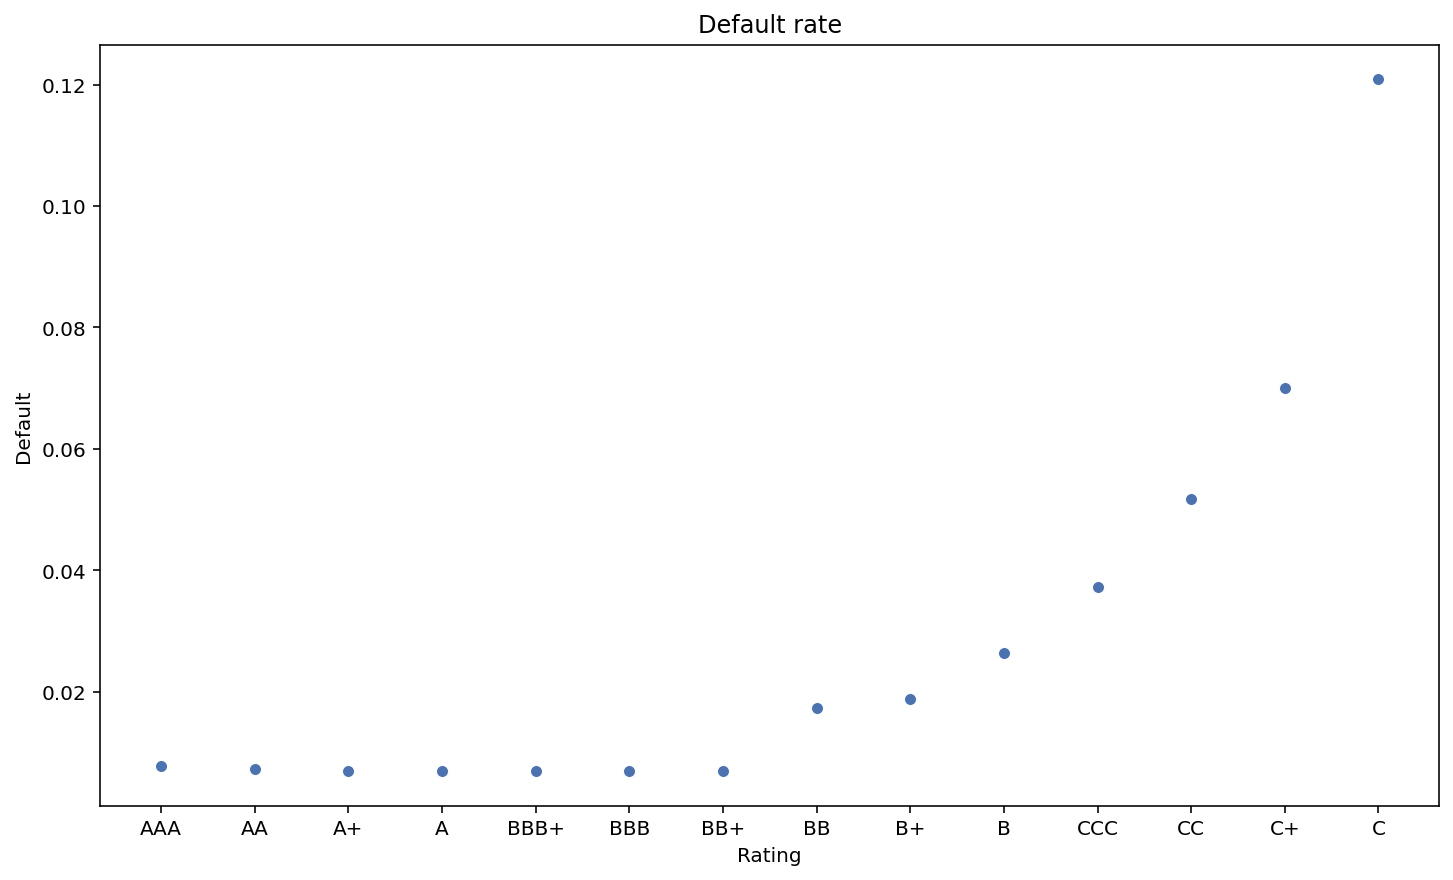

In [ ]:
# Observed default rate
plotRate(matrixAdj[:-1], 'Default rate', 'Rating', 'Default')

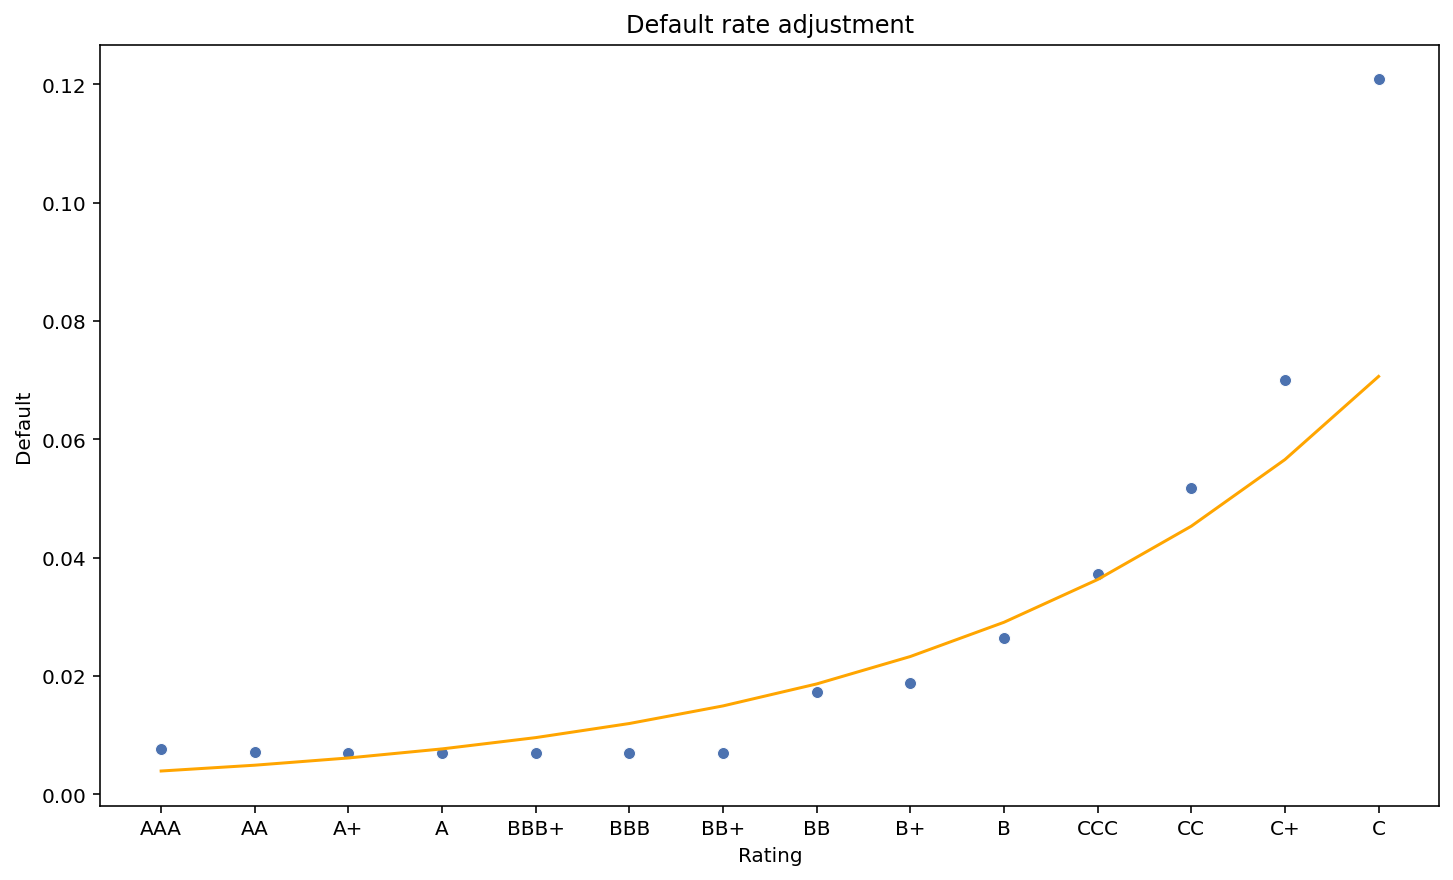

In [ ]:
# Default rate adjustment
X = np.arange(matrixAdj[:-1].shape[0]).reshape(-1, 1)
y = np.array(matrixAdj[:-1]['Default']).reshape(-1, 1)

# Log-linear regression model
model = LinearRegression()
model.fit(X, np.log(y))

# Result
matrixAdj['Default Adj'] = np.hstack((np.exp(model.predict(X)).reshape(1, -1)[0],
                                      matrixAdj[-1:]['Default'].values[0])) #Using actual default row

# Plot
plotRate(matrixAdj[:-1], 'Default rate adjustment', 'Rating', 'Default', 'Default Adj')

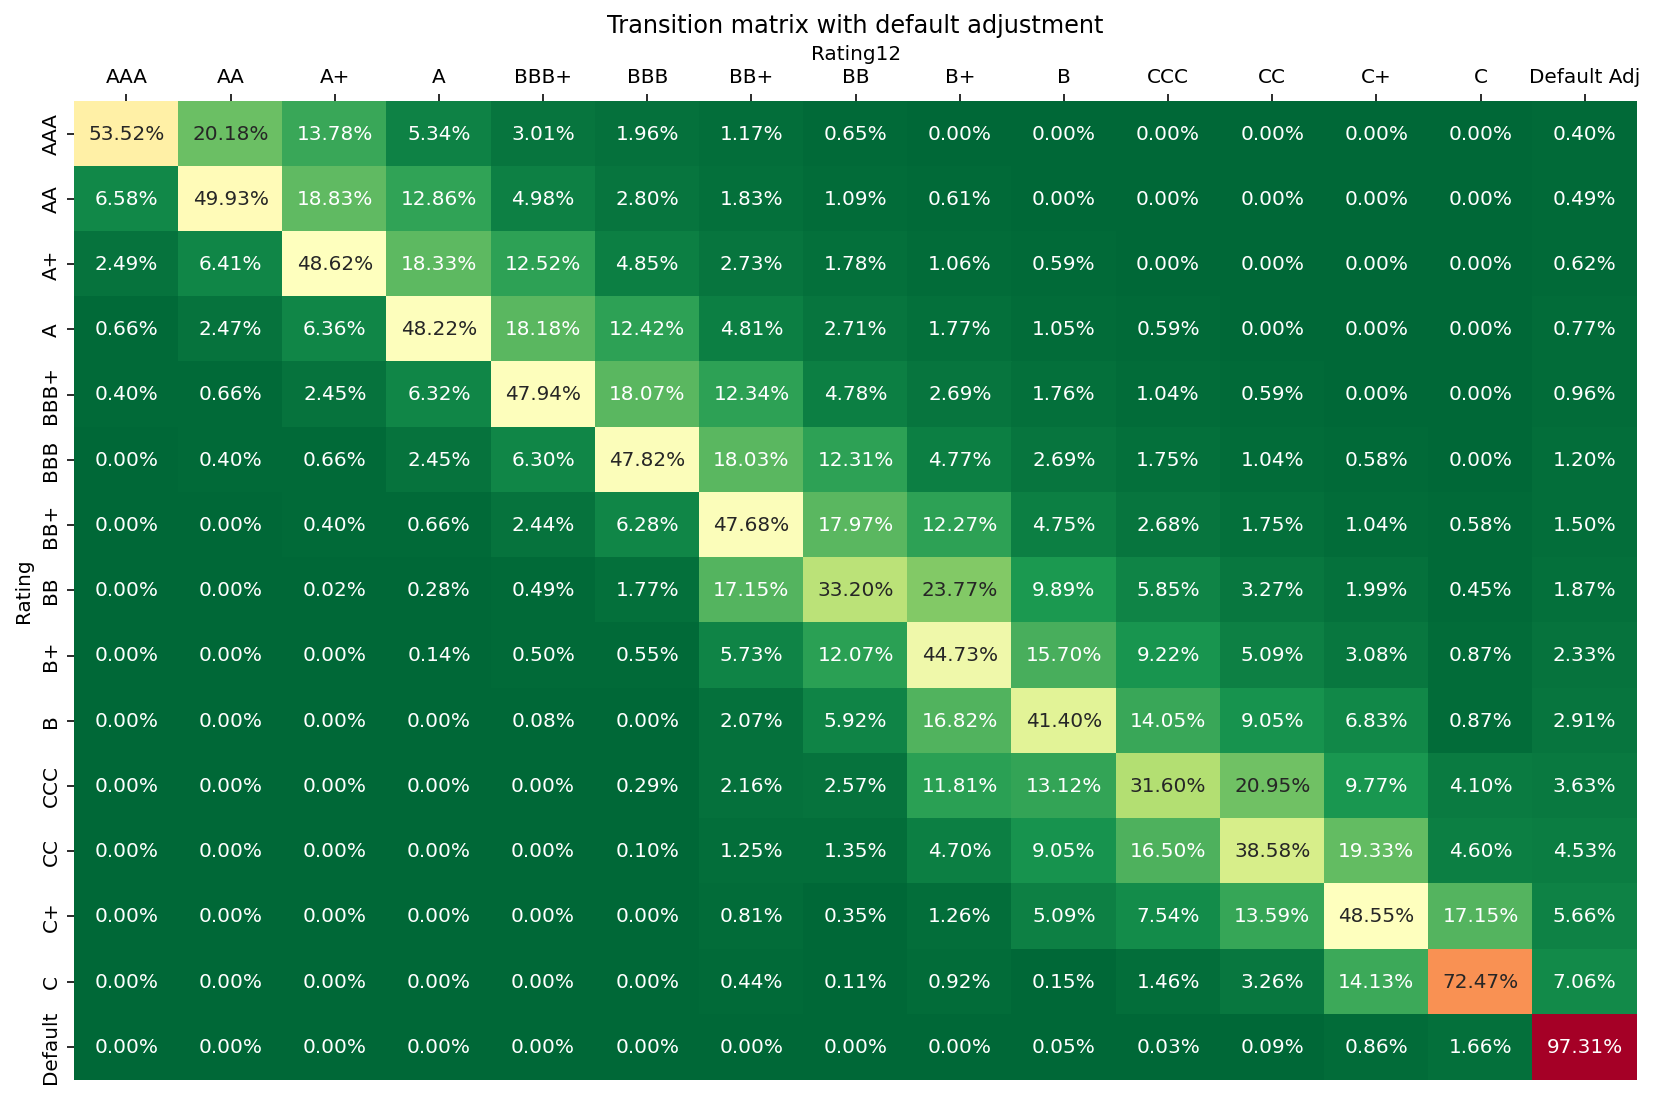

In [ ]:
# Matrix adjusted by default rate adjustment
matrixAdj = adjMatrix(matrixAdj, 'Default', 'Default Adj')

# Plot
plotMatrix(matrixAdj, 'Transition matrix with default adjustment')

In [ ]:
# Matrix multiplication for lifetime
years = 15 #Create lifetime PD for 15-years
lifetimeResults = None

lifetime = matrixAdj.to_numpy() #Select segment and convert to array
baseMatrix = lifetime.copy()
lifetimePD = lifetime[:, -1][:-1] #Keep first year PD but not 'Default' row
for i in range(years):
  if i == 0:
    pass
  else:
    lifetimeCum = np.dot(baseMatrix, lifetime[-baseMatrix.shape[0]:, :]) #Base * latest cumulative matrix
    lifetime = np.vstack((lifetime, lifetimeCum)) #Keep cumulative matrix
    lifetimePD = np.vstack((lifetimePD, lifetimeCum[:, -1][:-1])) #Keep only default bucket but not 'Default' row
    lifetimeResult = pd.DataFrame(lifetimePD, columns = range(lifetimePD.shape[1])) #Format to DataFrame
if lifetimeResults is None:
  lifetimeResults = lifetimeResult.copy()
else:
  lifetimeResults = pd.concat([lifetimeResults, lifetimeResult], axis = 0, ignore_index = False) #Keep index

# Create rating columns
lifetimeResults.columns = matrixAdj.index[:-1]

# Long table format
lifetimeResults['times'] = lifetimeResults.index + 1
lifetimeResults = pd.melt(lifetimeResults, id_vars = 'times', var_name = 'Rating', value_name = 'cumPD')
lifetimeResults.head(5)

,times,Rating,cumPD
0,1,AAA,0.003952
1,2,AAA,0.009036
2,3,AAA,0.015449
3,4,AAA,0.023384
4,5,AAA,0.032978


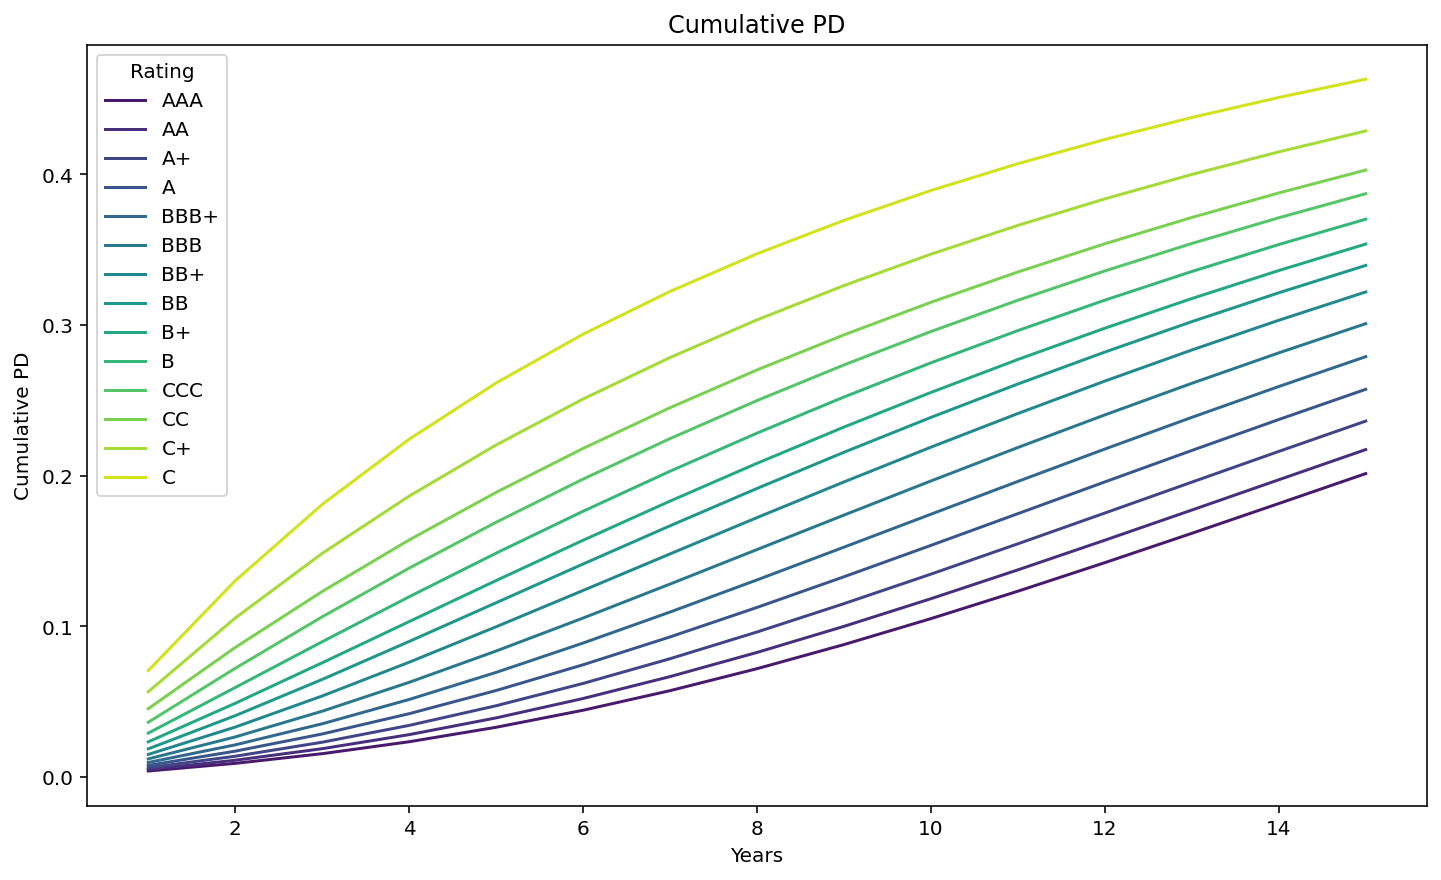

In [ ]:
# Plot
plt.figure(figsize = (12, 7))
with plt.style.context('seaborn-deep'):
  ax = sns.lineplot(x = 'times', y = 'cumPD', data = lifetimeResults,
                    hue = 'Rating', legend = 'full',
                    palette = 'viridis', ci = None)
  ax.set_title('Cumulative PD')
  ax.set(xlabel = 'Years', ylabel = 'Cumulative PD')
plt.show()